In [3]:
import numpy as np

# Backpropagation

## 1. Gradient of loss with respect to weights

In [4]:
inputs = np.array([[1, 2, 3, 2.5],
                   [2, 5, -1, 2],
                   [-1.5, 2.7, 3.3, -0.8]])

dL_dz = np.array([[1, 1, 1],
                  [2, 2, 2],
                  [3, 3, 3]])

# Gradient of loss with respect to weights
dL_dw = np.dot(inputs.T, dL_dz)
print(dL_dw)

[[ 0.5  0.5  0.5]
 [20.1 20.1 20.1]
 [10.9 10.9 10.9]
 [ 4.1  4.1  4.1]]


## 2. Gradient of loss with respect to biases

In [5]:
# Gradient of loss with respect to 
dL_db = np.sum(dL_dz, axis=0, keepdims=True)
print(dL_db)

[[6 6 6]]


## 3. Gradient of loss with respect to inputs

In [6]:
weights = np.array([[0.2, 0.8, -0.5, 1],
                    [0.5, -0.91, 0.26, -0.5],
                    [-0.26, -0.27, 0.17, 0.87]]).T
dL_dX = np.dot(dL_dz, weights.T)
print(dL_dX)

[[ 0.44 -0.38 -0.07  1.37]
 [ 0.88 -0.76 -0.14  2.74]
 [ 1.32 -1.14 -0.21  4.11]]


## 4. Adding the "backward" method in the Layer_Dense class

In [7]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dL_dz):
        self.dL_dw = np.dot(self.inputs.T, dL_dz)
        self.dL_db = np.sum(dL_dz, axis=0, keepdims=True)
        self.dL_dX = np.dot(dL_dz, self.weights.T)

## 5. Now adding the "backward" method in the ReLU Activation and backpropagating through the relu activation function

In [8]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dL_da):
        # Here dL_da is the gradient of L with respect to a. a is the output of the ReLU activation function, a = ReLU(z)
        # We have been given dL_da and we have to find dL_dz (gradient of loss with respect to z), here z is the output of the previous layer which will pass through the activation function
        # So we are basically backpropagating through the relu activation function
        self.dL_dz = dL_da.copy()
        self.dL_dz[self.inputs<=0] = 0

## 6. Defining the Categorical Cross Entropy Loss with "backward" method

In [9]:
class Loss:
    def calculate(self, y_pred, y_true):
        negative_log_likelihoods = self.forward(y_pred, y_true)
        avg_loss = np.mean(negative_log_likelihoods)
        return avg_loss

class Loss_CategoricalCrossEntropy(Loss): 
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        y_true = y_true

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(y_pred_clipped)), y_true]

        if len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, y_pred,y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        no_of_batches = len(y_pred)
        no_of_labels = len(y_pred[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(no_of_labels)[y_true]

        # Calculating gradient
        self.dL_dycap = -y_true / y_pred # Here ycap means the predictions
        
        # Applying the normalization on gradient
        self.normalized_dL_dycap = self.dL_dycap / no_of_batches

y_pred = np.array([[.1, .5, .3, .1],
                   [.2, .1, .4, .3],
                   [.3, .2, .1, .4]])
y_true = np.array([1, 2, 3])
loss_function = Loss_CategoricalCrossEntropy()
loss_function.backward(y_pred, y_true)
print(loss_function.dL_dycap)
print(loss_function.normalized_dL_dycap)

[[-0.  -2.  -0.  -0. ]
 [-0.  -0.  -2.5 -0. ]
 [-0.  -0.  -0.  -2.5]]
[[-0.         -0.66666667 -0.         -0.        ]
 [-0.         -0.         -0.83333333 -0.        ]
 [-0.         -0.         -0.         -0.83333333]]


## 7. Softmax classifier - combined Softmax activation with categorical cross entropy loss function for faster "backward" step

In [10]:
class Activation_Softmax:
    def forward(self, final_layer_outputs):
        exp_values = np.exp(final_layer_outputs - np.max(final_layer_outputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation_softmax = Activation_Softmax()
        self.loss_function = Loss_CategoricalCrossEntropy()
    
    def forward(self, final_layer_outputs, y_true):
        # Calculating softmax activation outputs
        self.activation_softmax.forward(final_layer_outputs)
        self.output = self.activation_softmax.output

        # Calculating loss
        self.loss = self.loss_function.calculate(self.output, y_true)
        return self.loss

    def backward(self, softmax_outputs, y_true):
        no_of_batches = len(softmax_outputs)

        # Converting the y_true to discrete vector if it is in one hot encoding
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dL_dz = softmax_outputs.copy()
        # Calculating gradient
        self.dL_dz[range(no_of_batches), y_true] -= 1

        # Applying normalization
        self.dL_dz = self.dL_dz / no_of_batches

softmax_outputs = np.array([[.7, .1, .2],
                            [.1, .5, .4],
                            [.02, .9, .08]])
class_targets = np.array([0, 1, 1])
softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()
softmax_loss.backward(softmax_outputs, class_targets)
normalized_dL_dz = softmax_loss.dL_dz
print("Gradients: Combined loss and softmax activation ->")
print(normalized_dL_dz)

Gradients: Combined loss and softmax activation ->
[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667 -0.03333333  0.02666667]]


# Coding the forward and backward pass

## 1. Load the spiral dataset

[[-0.          0.        ]
 [ 0.00326401  0.00955911]
 [ 0.01809646  0.00897997]
 [ 0.0287321   0.00963017]
 [ 0.02052672  0.03480144]]


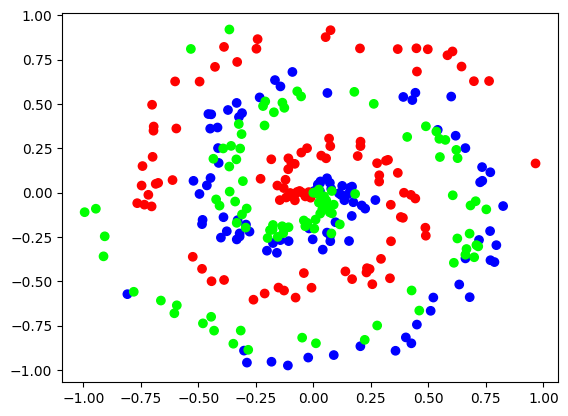

In [11]:
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

X, y = spiral_data(samples=100, classes=3)
print(X[:5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg")
plt.show()

## 2. Forward and Backward pass 

In [12]:
# Defining learning rate
learning_rate = 0.001

# Defining the classes
dense_layer1 = Layer_Dense(2, 3)
activation_relu = Activation_ReLU()
dense_layer2 = Layer_Dense(3, 3)
loss_activation_softmax = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Forward pass
dense_layer1.forward(X)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
loss_activation_softmax.forward(dense_layer2.output, y)
print("Softmax Outputs ->\n", loss_activation_softmax.output[:3])

# Printing performance matrices
print("Loss:", loss_activation_softmax.loss)
predictions = np.argmax(loss_activation_softmax.output, axis=1)
accuracy = np.mean(predictions==y)
print("Accuracy:", accuracy)

# Backward pass
loss_activation_softmax.backward(loss_activation_softmax.output, y)
dense_layer2.backward(loss_activation_softmax.dL_dz)
activation_relu.backward(dense_layer2.dL_dX)
dense_layer1.backward(activation_relu.dL_dz)

# Gradients of weights and biases
print(dense_layer1.dL_dw)
print(dense_layer1.dL_db)
print(dense_layer2.dL_dw)
print(dense_layer2.dL_db)

Softmax Outputs ->
 [[0.33333333 0.33333333 0.33333333]
 [0.33333324 0.33333358 0.33333318]
 [0.33333316 0.33333379 0.33333305]]
Loss: 1.0986125347146676
Accuracy: 0.32666666666666666
[[-2.83146659e-04  2.27302367e-05 -1.82437330e-04]
 [-2.20309695e-04 -1.99319912e-04 -4.76809413e-04]]
[[ 6.42675229e-04 -3.06824269e-05  7.85531213e-06]]
[[ 5.30086453e-05 -1.21438105e-05 -4.08648348e-05]
 [ 8.30012704e-05 -2.03343298e-04  1.20342027e-04]
 [ 1.61595332e-04 -1.29285407e-04 -3.23099247e-05]]
[[ 8.58705254e-06  1.19681645e-05 -2.05552170e-05]]


## 3. Applying gradient decent

In [13]:
dense_layer1.weights -= learning_rate*dense_layer1.dL_dw
dense_layer1.biases -= learning_rate*dense_layer1.dL_db
dense_layer2.weights -= learning_rate*dense_layer2.dL_dw
dense_layer2.biases -= learning_rate*dense_layer2.dL_db

## 4. Finding the loss and accuracy after gradient decent

In [14]:
# Forward pass
dense_layer1.forward(X)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
loss_activation_softmax.forward(dense_layer2.output, y)
print("Softmax Outputs ->\n", loss_activation_softmax.output[:3])

# Printing performance matrices
print("Loss:", loss_activation_softmax.loss)
predictions = np.argmax(loss_activation_softmax.output, axis=1)
accuracy = np.mean(predictions==y)
print("Accuracy:", accuracy)

Softmax Outputs ->
 [[0.33333333 0.33333333 0.33333334]
 [0.33333324 0.33333357 0.33333319]
 [0.33333315 0.33333379 0.33333306]]
Loss: 1.09861253375919
Accuracy: 0.32


# Coding Gradient Descent Optimizer

In [15]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dL_dw
        layer.biases += -self.learning_rate * layer.dL_db

## Coding the whole neural network using optimizer

In [27]:
# Loading the dataset
X, y = spiral_data(samples=100, classes=3)

# Defining the layers and activation functions
dense1 = Layer_Dense(2, 64)
relu_activation = Activation_ReLU()
dense2 = Layer_Dense(64, 3)
softmax_activation_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Defining the optimized SGD
optimizer_sdg = Optimizer_SGD()

for epoch in range(10001):
    # forward pass
    dense1.forward(X)
    relu_activation.forward(dense1.output)
    dense2.forward(relu_activation.output)
    softmax_activation_loss.forward(dense2.output, y)

    loss = softmax_activation_loss.loss
    predictions = np.argmax(softmax_activation_loss.output, axis=1)
    accuracy = np.mean(predictions == y)

    if epoch%100==0:
        print(f'Epoch: {epoch} Accuracy: {accuracy:.3f} Loss: {loss:.3f}')
    
    # backward pass
    softmax_activation_loss.backward(softmax_activation_loss.output, y)
    dense2.backward(softmax_activation_loss.dL_dz)
    relu_activation.backward(dense2.dL_dX)
    dense1.backward(relu_activation.dL_dz)

    # Updating weights and biases
    optimizer_sdg.update_params(dense1)
    optimizer_sdg.update_params(dense2)

Epoch: 0 Accuracy: 0.343 Loss: 1.099
Epoch: 100 Accuracy: 0.437 Loss: 1.071
Epoch: 200 Accuracy: 0.447 Loss: 1.066
Epoch: 300 Accuracy: 0.440 Loss: 1.063
Epoch: 400 Accuracy: 0.440 Loss: 1.062
Epoch: 500 Accuracy: 0.430 Loss: 1.059
Epoch: 600 Accuracy: 0.437 Loss: 1.056
Epoch: 700 Accuracy: 0.440 Loss: 1.048
Epoch: 800 Accuracy: 0.423 Loss: 1.051
Epoch: 900 Accuracy: 0.417 Loss: 1.046
Epoch: 1000 Accuracy: 0.407 Loss: 1.041
Epoch: 1100 Accuracy: 0.410 Loss: 1.039
Epoch: 1200 Accuracy: 0.423 Loss: 1.034
Epoch: 1300 Accuracy: 0.433 Loss: 1.026
Epoch: 1400 Accuracy: 0.450 Loss: 1.018
Epoch: 1500 Accuracy: 0.470 Loss: 1.009
Epoch: 1600 Accuracy: 0.473 Loss: 1.011
Epoch: 1700 Accuracy: 0.483 Loss: 0.986
Epoch: 1800 Accuracy: 0.453 Loss: 1.013
Epoch: 1900 Accuracy: 0.483 Loss: 0.985
Epoch: 2000 Accuracy: 0.417 Loss: 0.988
Epoch: 2100 Accuracy: 0.450 Loss: 0.975
Epoch: 2200 Accuracy: 0.503 Loss: 0.978
Epoch: 2300 Accuracy: 0.463 Loss: 0.968
Epoch: 2400 Accuracy: 0.473 Loss: 0.972
Epoch: 2500 

# Coding Gradient Descent Optimizer with learning rate decay

In [22]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1, decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epoch = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay*self.epoch))
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dL_dw
        layer.biases += -self.learning_rate * layer.dL_db

    def post_update_params(self):
        self.epoch += 1

# Coding the whole neural network using optimzer with decaying learning rate

In [26]:
# Loading the dataset
X, y = spiral_data(samples=1000, classes=3)

# Defining the layers and activation functions
dense1 = Layer_Dense(2, 128)
relu_activation = Activation_ReLU()
dense2 = Layer_Dense(128, 3)
softmax_activation_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Defining the optimized SGD
optimizer_sdg = Optimizer_SGD(decay=1e-3)

for epoch in range(10001):
    # forward pass
    dense1.forward(X)
    relu_activation.forward(dense1.output)
    dense2.forward(relu_activation.output)
    softmax_activation_loss.forward(dense2.output, y)

    loss = softmax_activation_loss.loss
    predictions = np.argmax(softmax_activation_loss.output, axis=1)
    accuracy = np.mean(predictions == y)

    if epoch%100==0:
        print(f'Epoch: {epoch} Accuracy: {accuracy:.3f} Loss: {loss:.3f} lr: {optimizer_sdg.current_learning_rate}')
    
    # backward pass
    softmax_activation_loss.backward(softmax_activation_loss.output, y)
    dense2.backward(softmax_activation_loss.dL_dz)
    relu_activation.backward(dense2.dL_dX)
    dense1.backward(relu_activation.dL_dz)

    # Updating weights and biases
    optimizer_sdg.pre_update_params()
    optimizer_sdg.update_params(dense1)
    optimizer_sdg.update_params(dense2)
    optimizer_sdg.post_update_params()

Epoch: 0 Accuracy: 0.313 Loss: 1.099 lr: 1
Epoch: 100 Accuracy: 0.411 Loss: 1.079 lr: 0.9099181073703367
Epoch: 200 Accuracy: 0.418 Loss: 1.070 lr: 0.8340283569641367
Epoch: 300 Accuracy: 0.416 Loss: 1.070 lr: 0.7698229407236336
Epoch: 400 Accuracy: 0.415 Loss: 1.070 lr: 0.7147962830593281
Epoch: 500 Accuracy: 0.416 Loss: 1.070 lr: 0.66711140760507
Epoch: 600 Accuracy: 0.418 Loss: 1.069 lr: 0.6253908692933083
Epoch: 700 Accuracy: 0.420 Loss: 1.068 lr: 0.5885815185403178
Epoch: 800 Accuracy: 0.423 Loss: 1.065 lr: 0.5558643690939411
Epoch: 900 Accuracy: 0.425 Loss: 1.058 lr: 0.526592943654555
Epoch: 1000 Accuracy: 0.432 Loss: 1.047 lr: 0.5002501250625312
Epoch: 1100 Accuracy: 0.440 Loss: 1.033 lr: 0.4764173415912339
Epoch: 1200 Accuracy: 0.398 Loss: 1.019 lr: 0.45475216007276037
Epoch: 1300 Accuracy: 0.446 Loss: 1.005 lr: 0.43497172683775553
Epoch: 1400 Accuracy: 0.452 Loss: 0.992 lr: 0.4168403501458941
Epoch: 1500 Accuracy: 0.498 Loss: 0.975 lr: 0.4001600640256102
Epoch: 1600 Accuracy: 